In [79]:
import pandas as pd

In [80]:
df = pd.read_csv('weatherHistory 1.csv')

In [81]:
# Sort chronologically
df = df.sort_values(by='Formatted Date').reset_index(drop=True)

In [82]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])

C:\Users\NikitaRampurkarV-Sof\AppData\Local\Temp\ipykernel_14308\882308080.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])


In [83]:
# Filter required columns
df= df[['Formatted Date', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)']]

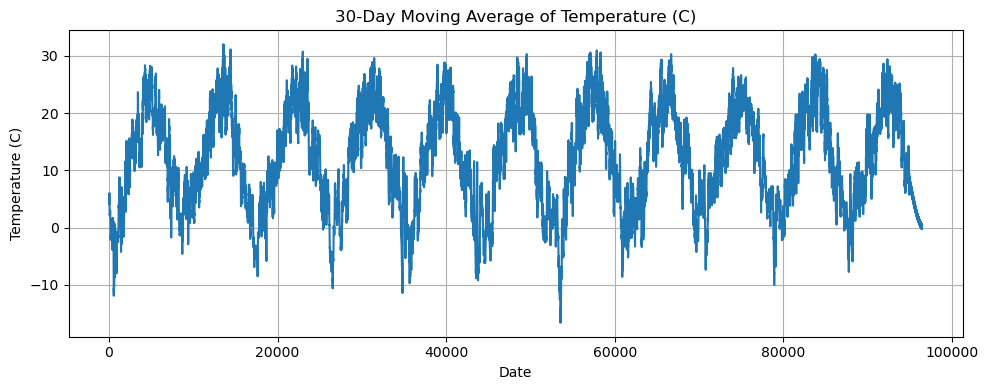

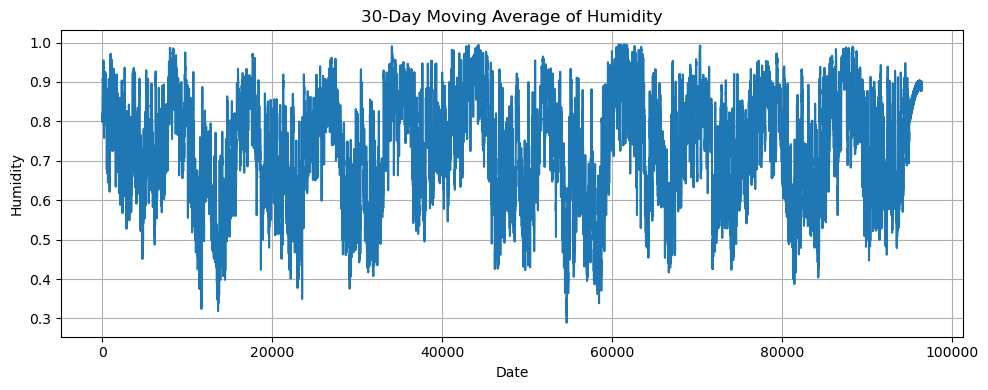

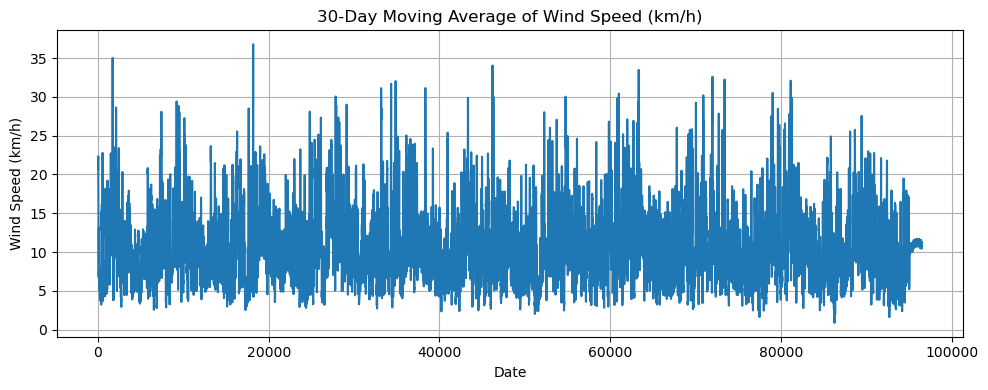

In [84]:
import matplotlib.pyplot as plt

# Filter only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Plot each column separately
for column in numeric_df.columns:
    plt.figure(figsize=(10, 4))
    numeric_df[column].rolling(window=30).mean().plot()
    plt.title(f'30-Day Moving Average of {column}')
    plt.ylabel(column)
    plt.xlabel('Date')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [85]:
print(df['Formatted Date'].dtype)

object


In [86]:
# Convert 'Formatted Date' to datetime if it's not already
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], errors='coerce')

In [87]:
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [88]:
data = df[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']]
data = data.asfreq('H')
data = data.fillna(method='ffill')

C:\Users\NikitaRampurkarV-Sof\AppData\Local\Temp\ipykernel_14308\3172178241.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.asfreq('H')
C:\Users\NikitaRampurkarV-Sof\AppData\Local\Temp\ipykernel_14308\3172178241.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [89]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df.sort_values(by='Formatted Date', ascending=True, inplace=True)
df.set_index('Formatted Date', inplace=True)

In [90]:
# Optional: Scale the data (helps with VAR stability)
# ---------- Step 2: Scaling ----------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

In [91]:
# ---------- Step 3: Split ----------
n_obs = 48 
train = scaled_df[:-n_obs]
test = scaled_df[-n_obs:]

In [92]:
# Fit the VAR model
model = VAR(scaled_data)
results = model.fit(maxlags=15, ic='aic')  # auto lag selection using AIC

In [93]:
# ---------- Step 4: Forecasting from today to end of year ----------
today = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))
end_of_year = pd.to_datetime(f"{today.year}-12-31")
n_future = int((end_of_year - today).total_seconds() // 3600) 

In [94]:
# Get lag order and last data points for forecasting
lag_order = results.k_ar
future_input = scaled_df.values[-lag_order:]
forecast_future_scaled = results.forecast(y=future_input, steps=n_future)
forecast_future = scaler.inverse_transform(forecast_future_scaled)

In [95]:
# Creating a new time index for future predictions
future_index = pd.date_range(start=today, periods=n_future, freq='H')
future_df = pd.DataFrame(forecast_future, columns=df.columns, index=future_index)

C:\Users\NikitaRampurkarV-Sof\AppData\Local\Temp\ipykernel_14308\2221024798.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=today, periods=n_future, freq='H')


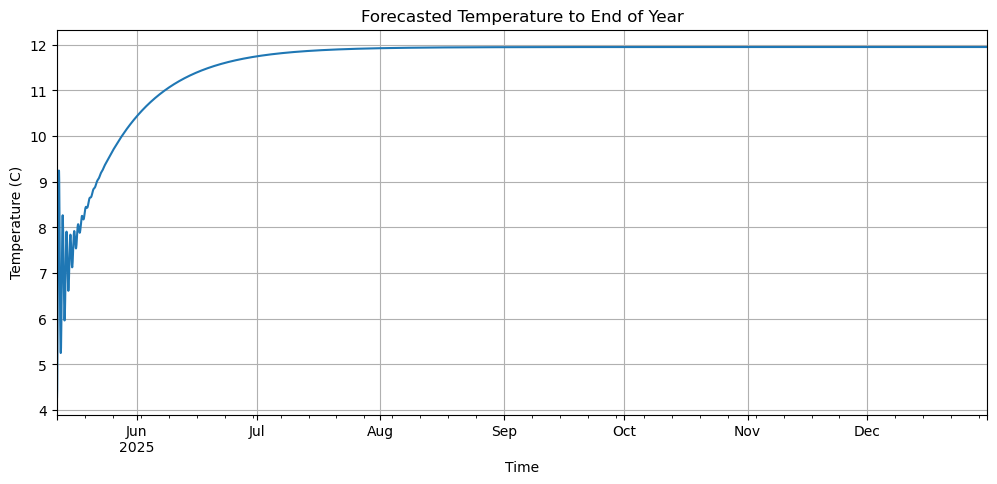

In [96]:
# Optional: Plot one variable
future_df['Temperature (C)'].plot(title='Forecasted Temperature to End of Year', figsize=(12, 5))
plt.ylabel('Temperature (C)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [98]:
# Final result
future_df.to_csv("forecast_from_today_to_end_of_year.csv")

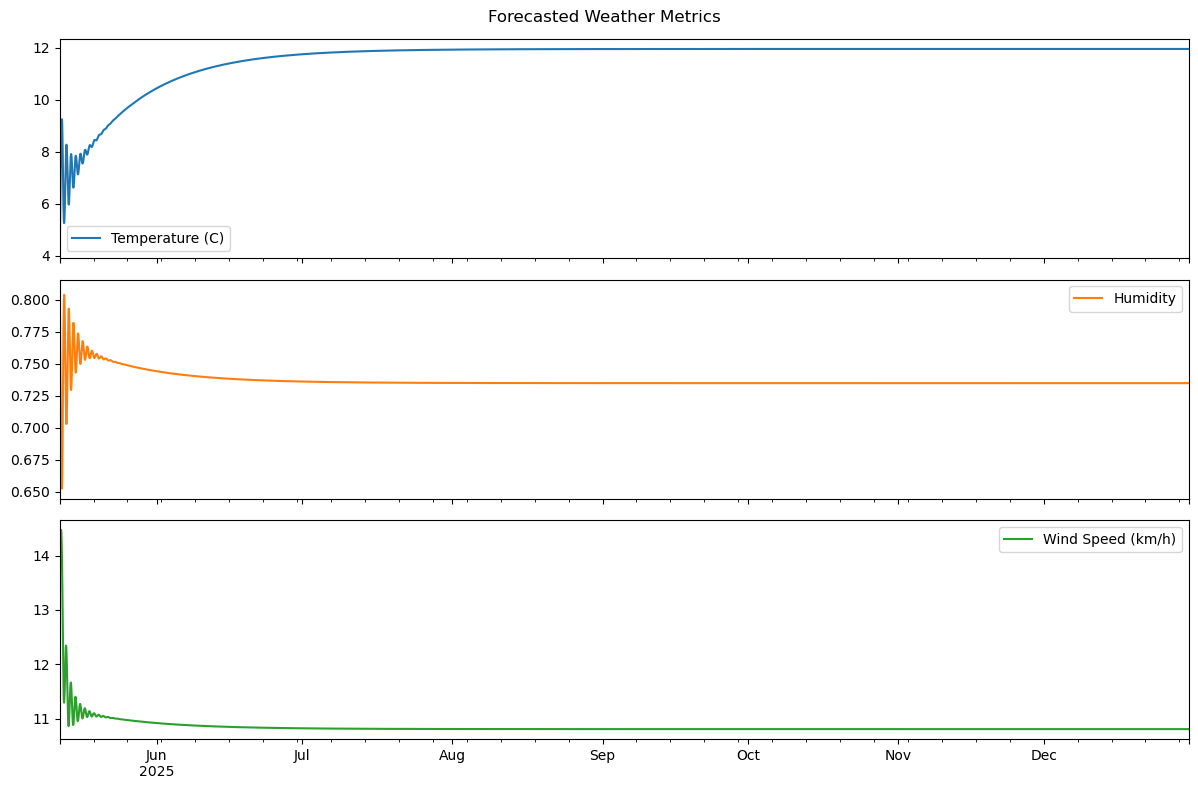

In [100]:
# 4. (Optional) Plot forecast
future_df.plot(subplots=True, figsize=(12, 8), title='Forecasted Weather Metrics')
plt.tight_layout()
plt.show()

In [104]:
# Select forecast values for the test period (48 hours)
future_test = forecast[:len(test)]

# Select actual values for the test period (48 hours)
actual_test = actual[:len(test)]

NameError: name 'forecast' is not defined